# GoEmotions Dataset

Preprocessing and EDA here

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import itertools
import string
import adjustText 
import collections
import re
import json

from tqdm.auto import tqdm

save_figures = True
data_path = "../Data"
figure_path = "../Figures"

## Data import

In [2]:
# set downoad to True if it is first time running this cell
# shuffle_files = False is good for debugging
# shuffle_files = True for later on when deploying the model for real
(reddit_train, reddit_test), reddit_info = tfds.load('goemotions', 
                                                     split=['train', 'test'],
                                                     with_info = True, 
                                                     shuffle_files = False,
                                                     download = False
                                                    )

In [3]:
print(f"reddit comment texts")
print(f" - train observations: {len(reddit_train)}")
print(f" - test observations : {len(reddit_test)}")
# print(reddit_info)
reddit_train_pd = tfds.as_dataframe(reddit_train.take(43410), reddit_info)
reddit_test_pd = tfds.as_dataframe(reddit_test.take(43410), reddit_info)

reddit comment texts
 - train observations: 43410
 - test observations : 5427


In [4]:
print(reddit_train_pd.shape)
print(reddit_train_pd.columns)
print(f"total columns:{len(reddit_train_pd.columns)}")
print(f"total emotion columns:{-1 + len(reddit_train_pd.columns)}")
display(reddit_train_pd.head(3))

print(reddit_test_pd.shape)
print(reddit_test_pd.columns)
print(f"total columns:{len(reddit_test_pd.columns)}")
print(f"total emotion columns:{-1 + len(reddit_test_pd.columns)}")
display(reddit_test_pd.head(3))

(43410, 29)
Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'comment_text', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral',
       'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness',
       'surprise'],
      dtype='object')
total columns:29
total emotion columns:28


,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,False,False,False,False,False,False,"b""It's just wholesome content, from questionab...",False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,True,False,False,False,False,False,b'This is actually awesome.',False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,"b""People really spend more than $10 in an app ...",True,False,False,...,False,False,False,False,False,False,False,False,True,False


(5427, 29)
Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'comment_text', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral',
       'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness',
       'surprise'],
      dtype='object')
total columns:29
total emotion columns:28


,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,False,False,False,False,True,False,"b""You're right, thanks for pointing that out, ...",False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,b'Molon labe!!!',False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,b'So this is what edging feels like',False,False,False,...,False,False,True,False,False,False,False,False,False,False


## EDA 

In [5]:
def save_figure(fig, name, figure_path = figure_path, save_figures = save_figures):
    if save_figures:
        filename = f"{figure_path}/{name}"
        fig.savefig(f"{filename}.pdf", 
                    dpi = 300, 
                    bbox_inches="tight")
        fig.savefig(f"{filename}.png", 
                    dpi = 300, 
                    bbox_inches="tight")
        fig.savefig(f"{filename}.svg", 
                    dpi = 300, 
                    bbox_inches="tight")

### Number of emotion tags per Reddit comment

In [6]:
emotion_columns = [
    "admiration", "amusement", "anger", "annoyance", "approval", 
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness", 
    "neutral", "optimism", "pride", "realization", "relief", 
    "remorse", "sadness","surprise"]

# no need to convert the tags to int
# for each_c in emotion_columns:
#     reddit_pd[each_c] = reddit_pd[each_c].astype('int')

reddit_train_pd["n_tags"] = reddit_train_pd[emotion_columns].sum(axis = 1)
reddit_test_pd["n_tags"] = reddit_test_pd[emotion_columns].sum(axis = 1)

In [7]:
reddit_train_pd[["comment_text", "n_tags"]]\
    .groupby("n_tags")\
    .agg("count")

,comment_text
n_tags,
1,36308
2,6541
3,532
4,28
5,1


### Distribution of Reddit comments by emotion

In [8]:
positive_emotion_columns = [
    "admiration", "amusement", "approval", "caring",
    "desire", "excitement", "gratitude", "joy", 
    "love", "optimism", "pride", "relief"]

negative_emotion_columns = [
    "anger", "annoyance", "disappointment", "disapproval",
    "disgust", "embarrassment", "fear", "grief", 
    "nervousness", "remorse", "sadness"]

neither_emotion_columns = [
    "confusion", "curiosity", "neutral", "realization", 
    "surprise"]

reddit_train_summary_pd = pd.DataFrame({"Count": reddit_train_pd[emotion_columns].sum()} )

reddit_train_summary_pd["Type"] = ""
reddit_train_summary_pd.loc[positive_emotion_columns, "Type"] = "Positive"
reddit_train_summary_pd.loc[negative_emotion_columns, "Type"] = "Negative"
reddit_train_summary_pd.loc[neither_emotion_columns, "Type"] = "Neither"

reddit_train_summary_pd["Type_Order"] = 0
reddit_train_summary_pd.loc[positive_emotion_columns, "Type_Order"] = 1
reddit_train_summary_pd.loc[negative_emotion_columns, "Type_Order"] = 2
reddit_train_summary_pd.loc[neither_emotion_columns, "Type_Order"] = 3

reddit_train_summary_pd.sort_values(by = ["Type_Order", "Count"], 
                                    ascending = [True, False], 
                                    inplace = True, 
                                    axis = 0)

reddit_train_summary_pd.eval("Raw_Weight = 1.0/Count", inplace = True)
raw_sum = reddit_train_summary_pd["Raw_Weight"].to_numpy().sum()
reddit_train_summary_pd.eval(f"Weight = Raw_Weight/{raw_sum}", inplace = True)

print(reddit_train_summary_pd["Weight"].to_numpy().sum())
    
display(reddit_train_summary_pd)

1.0000000000000002


,Count,Type,Type_Order,Raw_Weight,Weight
admiration,4130,Positive,1,0.000242,0.004345
approval,2939,Positive,1,0.000340,0.006106
gratitude,2662,Positive,1,0.000376,0.006741
amusement,2328,Positive,1,0.000430,0.007708
love,2086,Positive,1,0.000479,0.008603
optimism,1581,Positive,1,0.000633,0.011350
joy,1452,Positive,1,0.000689,0.012359
caring,1087,Positive,1,0.000920,0.016509
excitement,853,Positive,1,0.001172,0.021037
desire,641,Positive,1,0.001560,0.027995


In [9]:
positive_emotion_ordered = reddit_train_summary_pd.index[reddit_train_summary_pd["Type"] == "Positive"]
negative_emotion_ordered = reddit_train_summary_pd.index[reddit_train_summary_pd["Type"] == "Negative"]
neither_emotion_ordered = reddit_train_summary_pd.index[reddit_train_summary_pd["Type"] == "Neither"]

positive_emotion_ordered_cap = list(positive_emotion_ordered.str.capitalize())
negative_emotion_ordered_cap = list(negative_emotion_ordered.str.capitalize())
neither_emotion_ordered_cap = list(neither_emotion_ordered.str.capitalize())
# all_emotion_ordered_cap = reddit_train_summary_pd.index.str.capitalize()

all_emotion_ordered_cap = (positive_emotion_ordered_cap 
                           + [" "] 
                           + negative_emotion_ordered_cap 
                           + ["  "] 
                           + neither_emotion_ordered_cap)

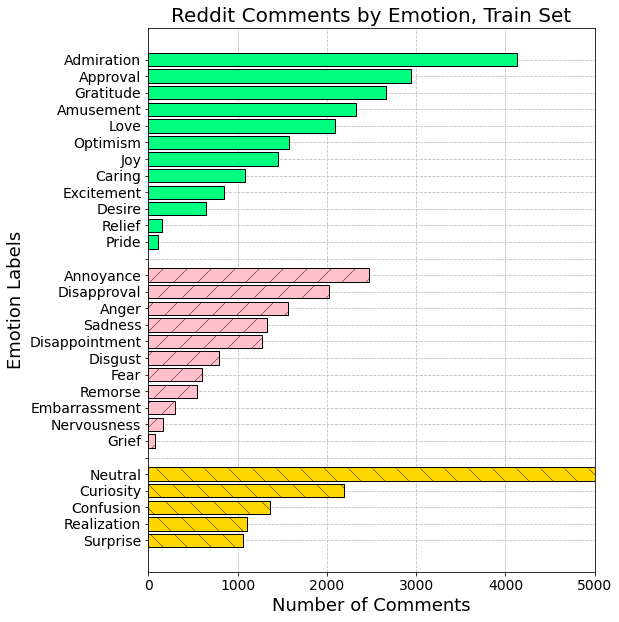

In [10]:
fig_bar_train, ax_bar_train = plt.subplots()

# plt.rcParams["hatch.color"] = "blue"
# doesn't work because edgecolor has higher priority
plt.rcParams["hatch.linewidth"] = 0.4

ax_bar_train.barh(y = positive_emotion_ordered,
                  width = reddit_train_summary_pd.loc[positive_emotion_ordered, "Count"], 
                  height = 0.8, 
                  color = "springgreen", 
                  edgecolor = "black", 
                  hatch = None,
                  zorder = 100,
                 )

ax_bar_train.barh(y = [" "], 
                  width = [0])

ax_bar_train.barh(y = negative_emotion_ordered,
                  width = reddit_train_summary_pd.loc[negative_emotion_ordered, "Count"], 
                  height = 0.8, 
                  color = "pink", 
                  edgecolor = "black",
                  hatch = "/",
                  zorder = 100,
                 )

ax_bar_train.barh(y = ["  "], 
                  width = [0])

ax_bar_train.barh(y = neither_emotion_ordered,
                  width = reddit_train_summary_pd.loc[neither_emotion_ordered, "Count"], 
                  height = 0.8, 
                  color = "gold", 
                  edgecolor = "black",
                  hatch = "\\",
                  zorder = 100,
                 )

ax_bar_train.set_yticks(ax_bar_train.get_yticks(), 
                        all_emotion_ordered_cap, 
                        fontsize = 14)

xticks = np.arange(0, 5500, 1000)
xtick_labels = [f"{x}" for x in xticks]
ax_bar_train.set_xticks(xticks)
ax_bar_train.set_xticklabels(xtick_labels, fontsize = 14)

ax_bar_train.invert_yaxis()
ax_bar_train.set_xlim(left = 0, right = 5000)


ax_bar_train.grid(linestyle = "dashed", 
            color = "#bfbfbf", 
            zorder = -100)

ax_bar_train.set_xlabel("Number of Comments", fontsize = 18) 
ax_bar_train.set_ylabel("Emotion Labels", fontsize = 18)
ax_bar_train.set_title("Reddit Comments by Emotion, Train Set", fontsize = 20)

fig_bar_train.set_size_inches([8, 10])

### Train vs Test Set

In [11]:
reddit_test_summary_pd = pd.DataFrame({"Count": reddit_test_pd[emotion_columns].sum()} )

reddit_test_summary_pd["Type"] = ""
reddit_test_summary_pd.loc[positive_emotion_columns, "Type"] = "Positive"
reddit_test_summary_pd.loc[negative_emotion_columns, "Type"] = "Negative"
reddit_test_summary_pd.loc[neither_emotion_columns, "Type"] = "Neither"

reddit_test_summary_pd["Type_Order"] = 0
reddit_test_summary_pd.loc[positive_emotion_columns, "Type_Order"] = 1
reddit_test_summary_pd.loc[negative_emotion_columns, "Type_Order"] = 2
reddit_test_summary_pd.loc[neither_emotion_columns, "Type_Order"] = 3

reddit_test_summary_pd.sort_values(by = ["Type_Order", "Count"], 
                                   ascending = [True, False], 
                                   inplace = True, 
                                   axis = 0)

display(reddit_test_summary_pd)

,Count,Type,Type_Order
admiration,504,Positive,1
gratitude,352,Positive,1
approval,351,Positive,1
amusement,264,Positive,1
love,238,Positive,1
optimism,186,Positive,1
joy,161,Positive,1
caring,135,Positive,1
excitement,103,Positive,1
desire,83,Positive,1


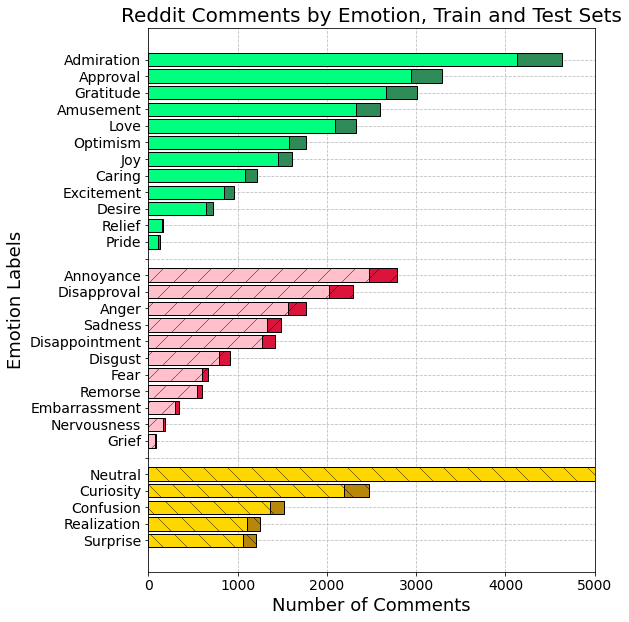

In [12]:
fig_bar_both, ax_bar_both = plt.subplots()

ax_bar_both.barh(y = positive_emotion_ordered,
                 width = reddit_train_summary_pd.loc[positive_emotion_ordered, "Count"],
                 height = 0.8, 
                 color = "springgreen", 
                 edgecolor = "black", 
                 zorder = 100,
                )

ax_bar_both.barh(y = [" "], 
                  width = [0])

ax_bar_both.barh(y = negative_emotion_ordered,
                 width = reddit_train_summary_pd.loc[negative_emotion_ordered, "Count"], 
                 height = 0.8, 
                 color = "pink", 
                 edgecolor = "black",
                 hatch = "/",
                 zorder = 100,
                )

ax_bar_both.barh(y = ["  "], 
                 width = [0])

ax_bar_both.barh(y = neither_emotion_ordered,
                 width = reddit_train_summary_pd.loc[neither_emotion_ordered, "Count"], 
                 height = 0.8, 
                 color = "gold", 
                 edgecolor = "black",
                 hatch = "\\",
                 zorder = 100,
                )


ax_bar_both.barh(y = positive_emotion_ordered,
                 left = reddit_train_summary_pd.loc[positive_emotion_ordered, "Count"],
                 width = reddit_test_summary_pd.loc[positive_emotion_ordered, "Count"],
                 height = 0.8, 
                 color = "seagreen", 
                 edgecolor = "black", 
                 zorder = 100,
                )

ax_bar_both.barh(y = negative_emotion_ordered,
                 left = reddit_train_summary_pd.loc[negative_emotion_ordered, "Count"], 
                 width = reddit_test_summary_pd.loc[negative_emotion_ordered, "Count"], 
                 height = 0.8, 
                 color = "crimson", 
                 edgecolor = "black",
                 hatch = "/",
                 zorder = 100,
                )

ax_bar_both.barh(y = neither_emotion_ordered,
                 left = reddit_train_summary_pd.loc[neither_emotion_ordered, "Count"], 
                 width = reddit_test_summary_pd.loc[neither_emotion_ordered, "Count"], 
                 height = 0.8, 
                 color = "darkgoldenrod", 
                 edgecolor = "black",
                 hatch = "\\",
                 zorder = 100,
                )



ax_bar_both.set_yticks(ax_bar_both.get_yticks(), 
                       all_emotion_ordered_cap, 
                       fontsize = 14)

xticks = np.arange(0, 5500, 1000)
xtick_labels = [f"{x}" for x in xticks]
ax_bar_both.set_xticks(xticks)
ax_bar_both.set_xticklabels(xtick_labels, fontsize = 14)

ax_bar_both.invert_yaxis()
ax_bar_both.set_xlim(left = 0, right = 5000)


ax_bar_both.grid(linestyle = "dashed", 
            color = "#bfbfbf", 
            zorder = -100)

ax_bar_both.set_xlabel("Number of Comments", fontsize = 18) 
ax_bar_both.set_ylabel("Emotion Labels", fontsize = 18)
ax_bar_both.set_title("Reddit Comments by Emotion, Train and Test Sets", fontsize = 20)

fig_bar_both.set_size_inches([8, 10])
save_figure(fig_bar_both, "Reddit Comment Distribution")

In [13]:
reddit_both_summary_pd = reddit_train_summary_pd.copy()
reddit_both_summary_pd.rename(columns = {"Count": "Train_Count"}, inplace = True)
reddit_both_summary_pd["Test_Count"] = reddit_test_summary_pd["Count"]
reddit_both_summary_pd.eval("Total_Count = Train_Count + Test_Count", inplace = True)
reddit_both_summary_pd.eval("Train_Ratio = Train_Count/Total_Count", inplace = True)
reddit_both_summary_pd.eval("Test_Ratio = Test_Count/Total_Count", inplace = True)

column_order = ["Train_Count", "Test_Count", "Total_Count", 
                "Train_Ratio", "Test_Ratio", 
                "Type", "Type_Order"]
reddit_both_summary_pd = reddit_both_summary_pd.reindex(columns = column_order)
display(reddit_both_summary_pd)

,Train_Count,Test_Count,Total_Count,Train_Ratio,Test_Ratio,Type,Type_Order
admiration,4130,504,4634,0.891239,0.108761,Positive,1
approval,2939,351,3290,0.893313,0.106687,Positive,1
gratitude,2662,352,3014,0.883212,0.116788,Positive,1
amusement,2328,264,2592,0.898148,0.101852,Positive,1
love,2086,238,2324,0.897590,0.102410,Positive,1
optimism,1581,186,1767,0.894737,0.105263,Positive,1
joy,1452,161,1613,0.900186,0.099814,Positive,1
caring,1087,135,1222,0.889525,0.110475,Positive,1
excitement,853,103,956,0.892259,0.107741,Positive,1
desire,641,83,724,0.885359,0.114641,Positive,1


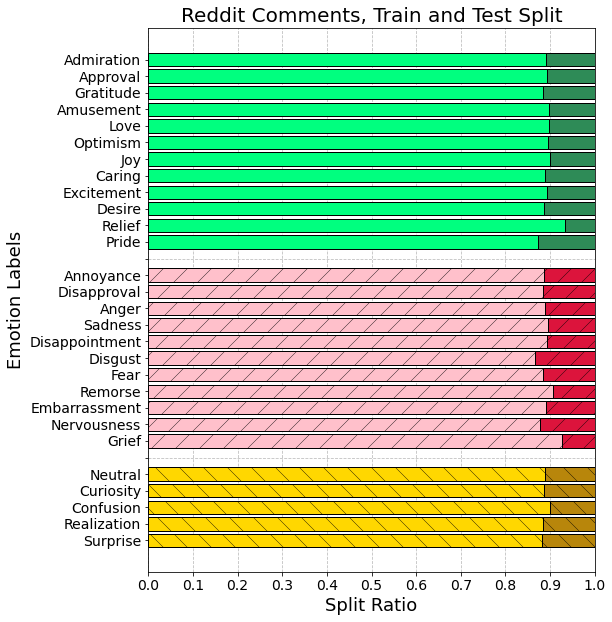

In [14]:
fig_bar_ratio, ax_bar_ratio = plt.subplots()

ax_bar_ratio.barh(y = positive_emotion_ordered,
                  width = reddit_both_summary_pd.loc[positive_emotion_ordered, "Train_Ratio"],
                  height = 0.8, 
                  color = "springgreen", 
                  edgecolor = "black", 
                  zorder = 100,
                 )

ax_bar_ratio.barh(y = [" "], 
                  width = [0])

ax_bar_ratio.barh(y = negative_emotion_ordered,
                  width = reddit_both_summary_pd.loc[negative_emotion_ordered, "Train_Ratio"], 
                  height = 0.8, 
                  color = "pink", 
                  edgecolor = "black",
                  hatch = "/",
                  zorder = 100,
                 )

ax_bar_ratio.barh(y = ["  "], 
                  width = [0])

ax_bar_ratio.barh(y = neither_emotion_ordered,
                  width = reddit_both_summary_pd.loc[neither_emotion_ordered, "Train_Ratio"], 
                  height = 0.8, 
                  color = "gold", 
                  edgecolor = "black",
                  hatch = "\\",
                  zorder = 100,
                 )


ax_bar_ratio.barh(y = positive_emotion_ordered,
                  left = reddit_both_summary_pd.loc[positive_emotion_ordered, "Train_Ratio"],
                  width = reddit_both_summary_pd.loc[positive_emotion_ordered, "Test_Ratio"],
                  height = 0.8, 
                  color = "seagreen", 
                  edgecolor = "black", 
                  zorder = 100,
                 )

ax_bar_ratio.barh(y = negative_emotion_ordered,
                  left = reddit_both_summary_pd.loc[negative_emotion_ordered, "Train_Ratio"], 
                  width = reddit_both_summary_pd.loc[negative_emotion_ordered, "Test_Ratio"], 
                  height = 0.8, 
                  color = "crimson", 
                  edgecolor = "black",
                  hatch = "/",
                  zorder = 100,
                 )

ax_bar_ratio.barh(y = neither_emotion_ordered,
                  left = reddit_both_summary_pd.loc[neither_emotion_ordered, "Train_Ratio"], 
                  width = reddit_both_summary_pd.loc[neither_emotion_ordered, "Test_Ratio"], 
                  height = 0.8, 
                  color = "darkgoldenrod", 
                  edgecolor = "black",
                  hatch = "\\",
                  zorder = 100,
                 )



ax_bar_ratio.set_yticks(ax_bar_ratio.get_yticks(), 
                        all_emotion_ordered_cap, 
                        fontsize = 14)

xticks = np.arange(0, 1.1, 0.1)
xtick_labels = [f"{x:1.1f}" for x in xticks]
ax_bar_ratio.set_xticks(xticks)
ax_bar_ratio.set_xticklabels(xtick_labels, fontsize = 14)

ax_bar_ratio.invert_yaxis()
ax_bar_ratio.set_xlim(left = 0.0, right = 1.0)


ax_bar_ratio.grid(linestyle = "dashed", 
             color = "#bfbfbf", 
             zorder = -100)

ax_bar_ratio.set_xlabel("Split Ratio", fontsize = 18) 
ax_bar_ratio.set_ylabel("Emotion Labels", fontsize = 18)
ax_bar_ratio.set_title("Reddit Comments, Train and Test Split", fontsize = 20)

fig_bar_ratio.set_size_inches([8, 10])
save_figure(fig_bar_both, "Reddit Comment Ratio")

## VAD mapping

NRC Word-Emotion Association Lexicon 

Source: https://saifmohammad.com/WebPages/nrc-vad.html

We can't include the lexicon itself, because the non-commercial research license forbids redistributing.

In [15]:
emotion_vad_mapping = np.array([
    [0.969,0.583,0.726],
    [0.929,0.837,0.803],
    [0.167,0.865,0.657],
    [0.167,0.718,0.342],
    [0.854,0.46,0.889],
    [0.635,0.469,0.5],
    [0.255,0.667,0.277],
    [0.75,0.755,0.463],
    [0.896,0.692,0.647],
    [0.115,0.49,0.336],
    [0.085,0.551,0.367],
    [0.052,0.775,0.317],
    [0.143,0.685,0.226],
    [0.896,0.684,0.731],
    [0.073,0.84,0.293],
    [0.885,0.441,0.61],
    [0.07,0.64,0.474],
    [0.98,0.824,0.794],
    [1,0.519,0.673],
    [0.163,0.915,0.241],
    [0.469,0.184,0.357],
    [0.949,0.565,0.814],
    [0.729,0.634,0.848],
    [0.554,0.51,0.836],
    [0.844,0.278,0.481],
    [0.103,0.673,0.377],
    [0.052,0.288,0.164],
    [0.875,0.875,0.562]])

emotion_vad_mapping_pd = pd.DataFrame(columns = ["valence", "arousal", "dominance"], 
                                      data = emotion_vad_mapping, 
                                      index = emotion_columns)
display(emotion_vad_mapping_pd)

,valence,arousal,dominance
admiration,0.969,0.583,0.726
amusement,0.929,0.837,0.803
anger,0.167,0.865,0.657
annoyance,0.167,0.718,0.342
approval,0.854,0.460,0.889
caring,0.635,0.469,0.500
confusion,0.255,0.667,0.277
curiosity,0.750,0.755,0.463
desire,0.896,0.692,0.647
disappointment,0.115,0.490,0.336


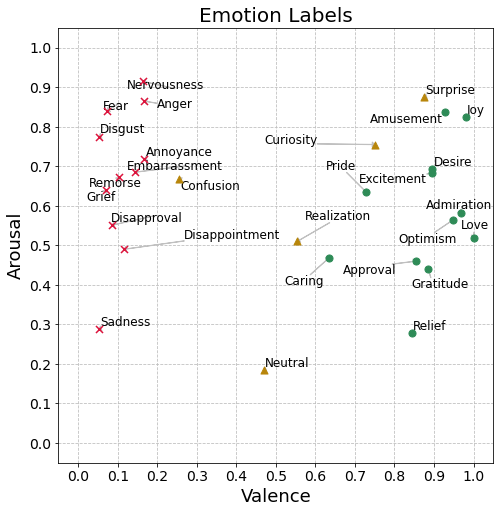

In [16]:
fig_mapping, ax_mapping = plt.subplots()
ax_mapping.scatter(x = emotion_vad_mapping_pd.loc[positive_emotion_ordered, "valence"], 
                   y = emotion_vad_mapping_pd.loc[positive_emotion_ordered, "arousal"], 
                   marker = "o",
                   s = 50,
                   color = "seagreen",
                   zorder = 100)

ax_mapping.scatter(x = emotion_vad_mapping_pd.loc[negative_emotion_ordered, "valence"], 
                   y = emotion_vad_mapping_pd.loc[negative_emotion_ordered, "arousal"], 
                   marker = "x",
                   s = 50,
                   color = "crimson",
                   zorder = 100)

ax_mapping.scatter(x = emotion_vad_mapping_pd.loc[neither_emotion_ordered, "valence"], 
                   y = emotion_vad_mapping_pd.loc[neither_emotion_ordered, "arousal"], 
                   marker = "^",
                   s = 50,
                   color = "darkgoldenrod",
                   zorder = 100)

annotations = []
for i, each_emotion_name in enumerate(emotion_columns):
    annotations.append(
        ax_mapping.annotate(each_emotion_name.capitalize(), 
                            (emotion_vad_mapping[i, 0], emotion_vad_mapping[i, 1]), 
                            # xytext = (emotion_vad_mapping[i, 0] + 0.05, emotion_vad_mapping[i, 1] + 0.05),
                            # xycoords = "data",
                            # arrowprops = {"width": 1, 
                            #               "headwidth": 10, 
                            #               "headlength": 5, 
                            #               "color":"black"},
                            zorder = 50,
                            fontsize = 12)
    )
    
adjustText.adjust_text(annotations,
                       expand_text = (1.025, 1.025),
                       expand_points = (1.05, 1.05),
                       expand_objects = (1.025, 1.025),
                       expand_align = (1.025, 1.025),
                       arrowprops = {"width": 0.25, 
                                     "headwidth": 5, 
                                     "headlength": 2.5, 
                                     "color":"silver", 
                                     "zorder":-100},
                      )
    
ax_mapping.grid(linestyle = "dashed", 
                color = "#bfbfbf", 
                zorder = -200)

xticks = np.arange(0.0, 1.1, 0.1)
xtick_labels = [f"{x:1.1f}" for x in xticks]
ax_mapping.set_xticks(xticks)
ax_mapping.set_xticklabels(xtick_labels, fontsize = 14)

yticks = np.arange(0.0, 1.1, 0.1)
ytick_labels = [f"{y:1.1f}" for y in yticks]
ax_mapping.set_yticks(yticks)
ax_mapping.set_yticklabels(ytick_labels, fontsize = 14)

ax_mapping.set_ylim(top = 1.05, bottom = -0.05)
ax_mapping.set_xlim(left = -0.05, right = 1.05)

ax_mapping.set_xlabel("Valence", fontsize = 18) 
ax_mapping.set_ylabel("Arousal", fontsize = 18)
ax_mapping.set_title("Emotion Labels", fontsize = 20)

fig_mapping.set_size_inches([8, 8])
ax_mapping.set_aspect(aspect = "equal")
save_figure(fig_mapping, "Reddit Comment Emotion Labels VA")

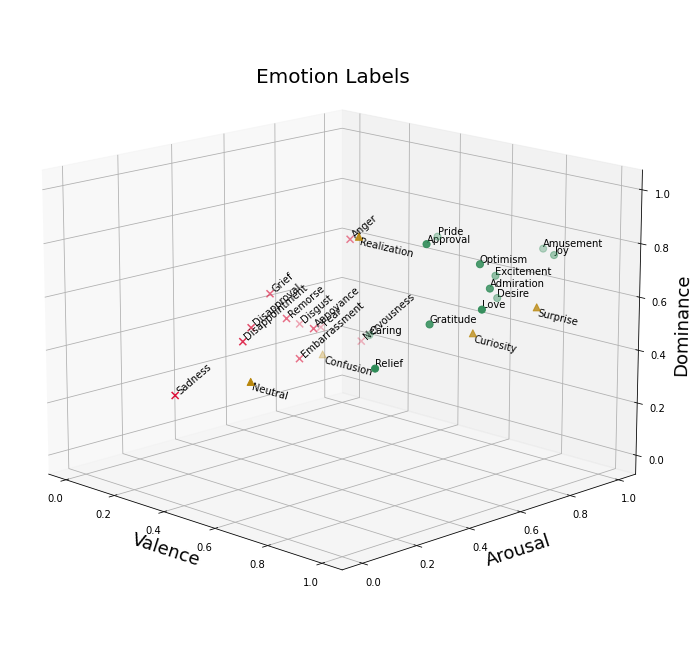

In [17]:
fig_mapping3D = plt.figure()
ax_mapping3D = fig_mapping3D.add_subplot(projection='3d')

ax_mapping3D.scatter(emotion_vad_mapping_pd.loc[positive_emotion_ordered, "valence"], 
                     emotion_vad_mapping_pd.loc[positive_emotion_ordered, "arousal"], 
                     zs = emotion_vad_mapping_pd.loc[positive_emotion_ordered, "dominance"], 
                     marker = "o",
                     s = 50,
                     color = "seagreen")


ax_mapping3D.scatter(emotion_vad_mapping_pd.loc[negative_emotion_ordered, "valence"], 
                     emotion_vad_mapping_pd.loc[negative_emotion_ordered, "arousal"], 
                     zs = emotion_vad_mapping_pd.loc[negative_emotion_ordered, "dominance"], 
                     marker = "x",
                     s = 50,
                     color = "crimson")

ax_mapping3D.scatter(emotion_vad_mapping_pd.loc[neither_emotion_ordered, "valence"], 
                     emotion_vad_mapping_pd.loc[neither_emotion_ordered, "arousal"], 
                     zs = emotion_vad_mapping_pd.loc[neither_emotion_ordered, "dominance"], 
                     marker = "^",
                     s = 50,
                     color = "darkgoldenrod")

annotations = []
for each_emotion_name in positive_emotion_ordered:
    annotations.append(
        ax_mapping3D.text(emotion_vad_mapping_pd.loc[each_emotion_name, "valence"], 
                          emotion_vad_mapping_pd.loc[each_emotion_name, "arousal"], 
                          emotion_vad_mapping_pd.loc[each_emotion_name, "dominance"],
                          each_emotion_name.capitalize(),
                          (1, 1, 0),
                          verticalalignment = "bottom",
                          fontsize = 10)
    )
    
for each_emotion_name in negative_emotion_ordered:
    annotations.append(
        ax_mapping3D.text(emotion_vad_mapping_pd.loc[each_emotion_name, "valence"], 
                          emotion_vad_mapping_pd.loc[each_emotion_name, "arousal"], 
                          emotion_vad_mapping_pd.loc[each_emotion_name, "dominance"],
                          each_emotion_name.capitalize(),
                          (0, 1, 0.60),
                          verticalalignment = "bottom",
                          fontsize = 10)
    )

for each_emotion_name in neither_emotion_ordered:
    annotations.append(
        ax_mapping3D.text(emotion_vad_mapping_pd.loc[each_emotion_name, "valence"], 
                          emotion_vad_mapping_pd.loc[each_emotion_name, "arousal"], 
                          emotion_vad_mapping_pd.loc[each_emotion_name, "dominance"],
                          each_emotion_name.capitalize(),
                          (1, 0, 0),
                          verticalalignment = "top",
                          fontsize = 10)
    )

ax_mapping3D.set_xlim(-0.05, 1.05)
ax_mapping3D.set_ylim(-0.05, 1.05)
ax_mapping3D.set_zlim(-0.05, 1.05)

ax_mapping3D.set_xlabel('Valence', fontsize = 18)
ax_mapping3D.set_ylabel('Arousal', fontsize = 18)
ax_mapping3D.set_zlabel('Dominance', fontsize = 18)
ax_mapping3D.set_title("Emotion Labels", fontsize = 20, 
                       y = 0.95)
    
fig_mapping3D.set_size_inches([12, 12])
ax_mapping3D.view_init(15, -45)
save_figure(fig_mapping3D, "Reddit Comment Emotion Labels VAD(3D)")

In [18]:
reddit_train_pd[["valence_raw", "arousal_raw", "dominance_raw"]] =\
    np.matmul(reddit_train_pd[emotion_columns].to_numpy(), 
              emotion_vad_mapping)

reddit_train_pd.eval("valence = valence_raw/n_tags", inplace = True)
reddit_train_pd.eval("arousal = arousal_raw/n_tags", inplace = True)
reddit_train_pd.eval("dominance = dominance_raw/n_tags", inplace = True)
display(reddit_train_pd.head())

,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,...,remorse,sadness,surprise,n_tags,valence_raw,arousal_raw,dominance_raw,valence,arousal,dominance
0,False,False,False,False,False,False,"b""It's just wholesome content, from questionab...",False,False,False,...,False,False,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570
1,True,False,False,False,False,False,b'This is actually awesome.',False,False,False,...,False,False,False,1,0.969,0.583,0.726,0.9690,0.5830,0.7260
2,False,False,False,False,False,False,"b""People really spend more than $10 in an app ...",True,False,False,...,False,True,False,2,0.307,0.955,0.441,0.1535,0.4775,0.2205
3,False,False,False,False,False,False,b'I grew up on the other side of Ama but live ...,False,False,False,...,False,False,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570
4,False,False,False,False,False,False,"b'What the problem? I mean, steak? Good. Dough...",False,True,False,...,False,False,False,2,0.835,1.306,0.830,0.4175,0.6530,0.4150


In [19]:
reddit_test_pd[["valence_raw", "arousal_raw", "dominance_raw"]] =\
    np.matmul(reddit_test_pd[emotion_columns].to_numpy(), 
              emotion_vad_mapping)

reddit_test_pd.eval("valence = valence_raw/n_tags", inplace = True)
reddit_test_pd.eval("arousal = arousal_raw/n_tags", inplace = True)
reddit_test_pd.eval("dominance = dominance_raw/n_tags", inplace = True)
display(reddit_test_pd.head())

,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,...,remorse,sadness,surprise,n_tags,valence_raw,arousal_raw,dominance_raw,valence,arousal,dominance
0,False,False,False,False,True,False,"b""You're right, thanks for pointing that out, ...",False,False,False,...,False,False,False,2,1.739,0.901,1.499,0.8695,0.4505,0.7495
1,False,False,False,False,False,False,b'Molon labe!!!',False,False,False,...,False,False,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570
2,False,False,False,False,False,False,b'So this is what edging feels like',False,False,False,...,False,False,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570
3,False,False,False,False,False,False,b'Just speak with a Sheffield accent lmao',False,False,False,...,False,False,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570
4,False,False,False,False,False,False,b'My husband and I have been circling the drai...,False,False,False,...,False,True,False,1,0.052,0.288,0.164,0.0520,0.2880,0.1640


## Weight

In [20]:
reddit_train_pd["Weight_raw"] =\
    np.matmul(reddit_train_pd[emotion_columns].to_numpy(), 
              reddit_train_summary_pd["Weight"].to_numpy())

reddit_train_pd.eval("Weight = Weight_raw/n_tags", inplace = True)

display(reddit_train_pd.head())

,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,...,surprise,n_tags,valence_raw,arousal_raw,dominance_raw,valence,arousal,dominance,Weight_raw,Weight
0,False,False,False,False,False,False,"b""It's just wholesome content, from questionab...",False,False,False,...,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570,0.059224,0.059224
1,True,False,False,False,False,False,b'This is actually awesome.',False,False,False,...,False,1,0.969,0.583,0.726,0.9690,0.5830,0.7260,0.004345,0.004345
2,False,False,False,False,False,False,"b""People really spend more than $10 in an app ...",True,False,False,...,False,2,0.307,0.955,0.441,0.1535,0.4775,0.2205,0.028525,0.014263
3,False,False,False,False,False,False,b'I grew up on the other side of Ama but live ...,False,False,False,...,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570,0.059224,0.059224
4,False,False,False,False,False,False,"b'What the problem? I mean, steak? Good. Dough...",False,True,False,...,False,2,0.835,1.306,0.830,0.4175,0.6530,0.4150,0.133796,0.066898


In [21]:
reddit_test_pd["Weight_raw"] =\
    np.matmul(reddit_test_pd[emotion_columns].to_numpy(), 
              reddit_train_summary_pd["Weight"].to_numpy())
# assigning the weights from the train set was intentional
# we have to pretend we have no idea about the relative frequencies in the test set
# also we never use the weights in the test set anyway

reddit_test_pd.eval("Weight = Weight_raw/n_tags", inplace = True)

display(reddit_test_pd.head())

,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,...,surprise,n_tags,valence_raw,arousal_raw,dominance_raw,valence,arousal,dominance,Weight_raw,Weight
0,False,False,False,False,True,False,"b""You're right, thanks for pointing that out, ...",False,False,False,...,False,2,1.739,0.901,1.499,0.8695,0.4505,0.7495,0.022136,0.011068
1,False,False,False,False,False,False,b'Molon labe!!!',False,False,False,...,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570,0.059224,0.059224
2,False,False,False,False,False,False,b'So this is what edging feels like',False,False,False,...,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570,0.059224,0.059224
3,False,False,False,False,False,False,b'Just speak with a Sheffield accent lmao',False,False,False,...,False,1,0.469,0.184,0.357,0.4690,0.1840,0.3570,0.059224,0.059224
4,False,False,False,False,False,False,b'My husband and I have been circling the drai...,False,False,False,...,False,1,0.052,0.288,0.164,0.0520,0.2880,0.1640,0.016167,0.016167


## Tokenize

### lower case
Convert everything to the lower case and keep the alphabetic words only. (i.e. no numbers or foreign characters)

In [22]:
##########DO NOT CHANGE#####################
PAD_TOKEN = "*PAD*"
UNK_TOKEN = "*UNK*"
WINDOW_SIZE = 30
##########DO NOT CHANGE#####################

In [23]:
%%time
i = 0
original_text_words_list = []
for each_comment in reddit_train_pd["comment_text"]:
    each_comment = each_comment.decode("utf-8").lower()
    original_text_words_list += re.findall(r"[a-z]+", each_comment)
    # i+= 1
    # if i > 10:
    #     break

CPU times: total: 203 ms
Wall time: 196 ms


### frequent words
Keep only the words that have appeared at least fifteen times

In [24]:
Word_Counts = collections.Counter(original_text_words_list)
total_distinct_words = len(Word_Counts)
Word_Counts_Sorted = Word_Counts.most_common(total_distinct_words)

# keep the words that have appeared at least five times
Frequent_Word_Counts = [(each_w, each_c) 
                        for each_w, each_c 
                        in Word_Counts_Sorted
                        if each_c > 14]

print(Frequent_Word_Counts[0:5], "\n")
print(Frequent_Word_Counts[-5::], "\n")
print(f"Total number of distinct words: {len(Word_Counts)}\n")
print(f"Total number of distinct frequent words: {len(Frequent_Word_Counts)}\n")

[('i', 20777), ('the', 18003), ('to', 12600), ('a', 12363), ('you', 11459)] 

[('increase', 15), ('cunt', 15), ('included', 15), ('flip', 15), ('childhood', 15)] 

Total number of distinct words: 25638

Total number of distinct frequent words: 2678



### dictionary
Save the frequent words as a dictionary. Remember to include the pad and unk tokens.

In [25]:
frequent_words_list = [each_w 
                       for each_w, each_c 
                       in Frequent_Word_Counts]

word_set = sorted(set([UNK_TOKEN, PAD_TOKEN] + frequent_words_list))
word_to_index_dict = {word:index for index, word in enumerate(word_set)}

print("First 30 word tokens")
print(list(word_to_index_dict.items())[0:30], "\n")

with open(f"{data_path}/token_dictionary.json", "w") as outfile:
    json.dump(word_to_index_dict, outfile)

First 30 word tokens
[('*PAD*', 0), ('*UNK*', 1), ('a', 2), ('ability', 3), ('able', 4), ('abortion', 5), ('about', 6), ('above', 7), ('absolute', 8), ('absolutely', 9), ('abuse', 10), ('abusive', 11), ('accent', 12), ('accept', 13), ('accepted', 14), ('accident', 15), ('accidentally', 16), ('according', 17), ('account', 18), ('accurate', 19), ('across', 20), ('act', 21), ('acting', 22), ('action', 23), ('actions', 24), ('active', 25), ('actively', 26), ('acts', 27), ('actual', 28), ('actually', 29)] 



### window size
The window size can be 30

In [26]:
%%time
i = 0
len_list = []
for each_comment in reddit_train_pd["comment_text"]:
    each_comment = each_comment.decode("utf-8").lower()
    original_text_words_list = re.findall(r"[a-z]+", each_comment)
    len_list.append(len(original_text_words_list))

len_array = np.array(len_list)
print(np.amax(len_array))

Len_Counts = collections.Counter(len_list)
Len_Counts = Len_Counts.most_common(35)
print(Len_Counts)

35
[(9, 2098), (5, 2075), (11, 2063), (12, 2049), (10, 2036), (14, 2031), (13, 1993), (8, 1972), (4, 1969), (3, 1964), (15, 1962), (6, 1947), (7, 1942), (16, 1870), (17, 1767), (18, 1715), (19, 1551), (20, 1502), (21, 1373), (22, 1298), (23, 1227), (24, 1165), (25, 1014), (2, 896), (26, 779), (27, 573), (28, 285), (1, 168), (29, 93), (30, 23), (31, 4), (0, 3), (32, 2), (35, 1)]
CPU times: total: 172 ms
Wall time: 175 ms


### padding
Pad the comments

In [27]:
%%time
padded_comment_list = []

for each_comment in reddit_train_pd["comment_text"]:
    each_comment = each_comment.decode("utf-8").lower()
    each_comment = re.findall(r"[a-z]+", each_comment)
    
    padded_comment = each_comment[:WINDOW_SIZE]
    padded_comment += [PAD_TOKEN] * (WINDOW_SIZE - len(padded_comment))
    padded_comment_list.append(padded_comment)
    
padded_comment_list_test = []

for each_comment in reddit_test_pd["comment_text"]:
    each_comment = each_comment.decode("utf-8").lower()
    each_comment = re.findall(r"[a-z]+", each_comment)
    
    padded_comment = each_comment[:WINDOW_SIZE]
    padded_comment += [PAD_TOKEN] * (WINDOW_SIZE - len(padded_comment))
    padded_comment_list_test.append(padded_comment)

CPU times: total: 328 ms
Wall time: 327 ms


In [28]:
print(padded_comment_list[0:5])
print(padded_comment_list_test[0:5])

[['it', 's', 'just', 'wholesome', 'content', 'from', 'questionable', 'sources', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*'], ['this', 'is', 'actually', 'awesome', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*'], ['people', 'really', 'spend', 'more', 'than', 'in', 'an', 'app', 'game', 'i', 'mean', 'an', 'actual', 'video', 'game', 'i', 'can', 'understand', 'but', 'that', 's', 'just', 'sad', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*'], ['i', 'grew', 'up', 'on', 'the', 'other', 'side', 'of', 'ama', 'but', 'live', 'in', 'tulia', 'now', 'i', 'will', 'have', 'some', 'el', 'burrito', 'for', 'you', '*PAD*', '*PAD*', '*PAD*', '*PAD*', '*PAD*',

### Tokenize
Tokenize the padded comments

In [29]:
%%time
padded_comment_array = np.stack(
    [[word_to_index_dict[word] 
      if word in word_to_index_dict 
      else word_to_index_dict[UNK_TOKEN] 
           for word 
           in comment] for comment in padded_comment_list])
print(padded_comment_array[0:5])

padded_comment_array_test = np.stack(
    [[word_to_index_dict[word] 
      if word in word_to_index_dict 
      else word_to_index_dict[UNK_TOKEN] 
           for word 
           in comment] for comment in padded_comment_list_test])
print(padded_comment_array_test[0:5])

[[1245 1992 1264 2592  491  933    1 2176    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [2359 1237   29  172    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1704 1898 2189 1522 2335 1189   84  112  951 1161 1454   84   28 2514
   951 1161  347 2464  329 2338 1992 1264 1994    0    0    0    0    0
     0    0]
 [1161 1012 2480 1632 2340 1658 2100 1612    1  329 1370 1189    1 1598
  1161 2598 1064 2155    1    1  907 2670    0    0    0    0    0    0
     0    0]
 [2578 2340 1817 1161 1454    1  997    1  997 1161  662 2292 2040   84
  1243    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
[[2670 1885 1963 2337  907 1765 2338 1663 1161 2507  720 1245 1598  362
  1632    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1    1    0    0    0    0    0    0    0    0    0 

In [30]:
reddit_train_pd.to_parquet(f"{data_path}/reddit_train.parquet")
reddit_test_pd.to_parquet(f"{data_path}/reddit_test.parquet")

In [31]:
with open(f"{data_path}/reddit_train_tokens.npy", "wb") as f:
    np.save(f, 
            padded_comment_array, 
            allow_pickle = False)
    
with open(f"{data_path}/reddit_test_tokens.npy", "wb") as f:
    np.save(f, 
            padded_comment_array_test, 
            allow_pickle = False)

In [32]:
train_pad_proportion = np.sum(padded_comment_array == 0)/np.prod(padded_comment_array.shape)
train_unk_proportion = np.sum(padded_comment_array == 1)/np.prod(padded_comment_array.shape)
print(f"train_pad_proportion = {train_pad_proportion}")
print(f"train_unk_proportion = {train_unk_proportion}")

train_pad_proportion = 0.5592328956461645
train_unk_proportion = 0.045780542117791596


In [33]:
test_pad_proportion = np.sum(padded_comment_array_test == 0)/np.prod(padded_comment_array_test.shape)
test_unk_proportion = np.sum(padded_comment_array_test == 1)/np.prod(padded_comment_array_test.shape)
print(f"test_pad_proportion = {test_pad_proportion}")
print(f"test_pad_proportion = {test_unk_proportion}")

test_pad_proportion = 0.5630673791536146
test_pad_proportion = 0.0468767274737424


In [34]:
index_to_word_dict = {i:w for w,i in word_to_index_dict.items()}

In [35]:
print(reddit_test_pd.loc[365, "comment_text"])

for i in padded_comment_array_test[365]:
    print(index_to_word_dict[i], end = " ")

b'This is too accurate \xf0\x9f\x98\x82'
this is too accurate *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* 

In [36]:
print(reddit_train_pd.loc[365, "comment_text"])

for i in padded_comment_array[365]:
    print(index_to_word_dict[i], end = " ")

b'(It was a joke)'
it was a joke *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* *PAD* 